In [1]:
import findspark

In [2]:
findspark.init("/opt/manual/spark")

In [3]:
from pyspark.sql import SparkSession, functions as F
import pandas as pd

In [4]:
spark = SparkSession.builder \
.appName("Churn Scoring with GBT") \
.master("yarn") \
.getOrCreate()

In [5]:
spark.version

'3.0.0'

In [6]:
! hdfs dfs -ls /user/train/datasets/churn-telecom

Found 3 items
-rw-r--r--   1 train supergroup    5213392 2020-11-19 21:02 /user/train/datasets/churn-telecom/cell2cellholdout.csv
-rw-r--r--   1 train supergroup   13416201 2020-11-19 21:02 /user/train/datasets/churn-telecom/cell2celltrain.csv
drwxr-xr-x   - train supergroup          0 2020-11-19 21:02 /user/train/datasets/churn-telecom/cell2celltrain_clean_parquet


## Read train data

In [7]:
df1 = spark.read.format("parquet") \
.load("hdfs://localhost:9000/user/train/datasets/churn-telecom/cell2celltrain_clean_parquet")

## Explore train data

In [8]:
# Since there are many columns we'd better explore part by part 
df1.select(df1.columns[40:]) \
.limit(46).toPandas()

,OptOutMailings,NonUSTravel,OwnsComputer,HasCreditCard,RetentionCalls,RetentionOffersAccepted,NewCellphoneUser,NotNewCellphoneUser,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,No,No,Yes,Yes,1.0,0.0,No,No,0.0,4.0,No,0.0,30.0,Yes,1-Highest,Suburban,Professional,No
1,No,No,Yes,Yes,0.0,0.0,Yes,No,0.0,5.0,No,0.0,30.0,No,4-Medium,Suburban,Professional,Yes
2,No,No,No,Yes,0.0,0.0,Yes,No,0.0,6.0,No,0.0,130.0,No,3-Good,Town,Crafts,Yes
3,No,No,No,Yes,0.0,0.0,Yes,No,0.0,6.0,No,0.0,10.0,No,4-Medium,Other,Other,No
4,No,No,Yes,Yes,0.0,0.0,No,Yes,0.0,9.0,No,1.0,10.0,No,1-Highest,Other,Professional,Yes
5,No,Yes,No,Yes,0.0,0.0,Yes,No,0.0,1.0,No,1.0,30.0,No,3-Good,Other,Other,Yes
6,No,Yes,No,Yes,0.0,0.0,No,Yes,0.0,9.0,No,1.0,30.0,No,1-Highest,Other,Self,Yes
7,No,No,No,Yes,0.0,0.0,Yes,No,0.0,6.0,No,0.0,30.0,No,1-Highest,Other,Professional,No
8,No,No,No,Yes,0.0,0.0,Yes,No,0.0,9.0,No,0.0,80.0,No,1-Highest,Other,Other,Yes
9,No,No,Yes,Yes,0.0,0.0,Yes,No,0.0,5.0,No,1.0,30.0,No,3-Good,Other,Professional,No


In [9]:
# Schema change analysis

# MonthlyRevenue, MonthlyMinutes, TotalRecurringCharge, OverageMinutes, PercChangeMinutes, PercChangeRevenues
# Handsets, HandsetModels, CurrentEquipmentDays, AgeHH1, AgeHH2  to integer

# DirectorAssistedCalls, HandsetPrice to float

In [10]:
len(df1.columns)

58

In [11]:
df1.printSchema()

root
 |-- CustomerID: integer (nullable = true)
 |-- Churn: string (nullable = true)
 |-- MonthlyRevenue: double (nullable = true)
 |-- MonthlyMinutes: double (nullable = true)
 |-- TotalRecurringCharge: double (nullable = true)
 |-- DirectorAssistedCalls: double (nullable = true)
 |-- OverageMinutes: double (nullable = true)
 |-- RoamingCalls: double (nullable = true)
 |-- PercChangeMinutes: double (nullable = true)
 |-- PercChangeRevenues: double (nullable = true)
 |-- DroppedCalls: double (nullable = true)
 |-- BlockedCalls: double (nullable = true)
 |-- UnansweredCalls: double (nullable = true)
 |-- CustomerCareCalls: double (nullable = true)
 |-- ThreewayCalls: double (nullable = true)
 |-- ReceivedCalls: double (nullable = true)
 |-- OutboundCalls: double (nullable = true)
 |-- InboundCalls: double (nullable = true)
 |-- PeakCallsInOut: double (nullable = true)
 |-- OffPeakCallsInOut: double (nullable = true)
 |-- DroppedBlockedCalls: double (nullable = true)
 |-- CallForwardingC

In [12]:
# Null check
for(col_name, col_type) in zip(df1.columns, df1.dtypes):
    null_count = df1.filter( (F.col(col_name).isNull()) | (F.col(col_name) == "")).count()
    if(  null_count > 0 ):
        print("{} {} type has {} null values".format(col_name, col_type[1], null_count))

# Distribution of Output/Target variable

In [13]:
df1.select("Churn").groupBy("Churn").count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|   No|36335|
|  Yes|14711|
+-----+-----+



<AxesSubplot:>

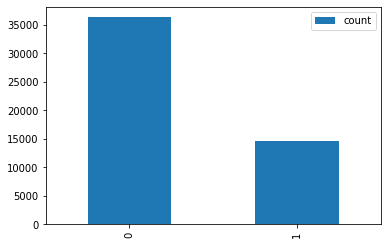

In [14]:
df1.select("Churn").groupBy("Churn").count().toPandas().plot(kind='bar')

# Data Preperation for the Model

In [15]:
categoric_cols = []
numeric_cols = []
discarted_cols = []
label_col = []

In [16]:
# column seperation
for col_name in df1.dtypes:
    if (col_name[0] not in []):
        if (col_name[1] == 'string'):
            categoric_cols.append(col_name[0])
        else: numeric_cols.append(col_name[0])

In [17]:
for col_name in categoric_cols:
    df1.groupBy(col_name).agg(F.count("*").alias("TotalCount")).orderBy(F.desc("TotalCount")).show()

+-----+----------+
|Churn|TotalCount|
+-----+----------+
|   No|     36335|
|  Yes|     14711|
+-----+----------+

+-----------+----------+
|ServiceArea|TotalCount|
+-----------+----------+
|  NYCBRO917|      1684|
|  HOUHOU281|      1510|
|  DALDAL214|      1498|
|  NYCMAN917|      1182|
|  APCFCH703|       783|
|  DALFTW817|       782|
|  SANSAN210|       724|
|  APCSIL301|       670|
|  SANAUS512|       612|
|  SFROAK510|       605|
|  SFRSFR415|       565|
|  NYCQUE917|       533|
|  ATLANE678|       524|
|  PHXPHX602|       512|
|  SFRSCL408|       508|
|  ATLATL678|       507|
|  STLSTL314|       497|
|  OHICOL614|       486|
|  MINMIN612|       481|
|  NEVLVS702|       479|
+-----------+----------+
only showing top 20 rows

+------------+----------+
|ChildrenInHH|TotalCount|
+------------+----------+
|          No|     38678|
|         Yes|     12368|
+------------+----------+

+------------------+----------+
|HandsetRefurbished|TotalCount|
+------------------+----------+
|     

In [18]:
# column seperation after analysis
categoric_cols = []
numeric_cols = []
# Why we discard these? Because they have high cardinality. In other words they have too many distinct categories
# Adding them to model will not do good if not too bad.
discarted_cols = ['CustomerID', 'ServiceArea']
label_col = ['Churn']

In [19]:
for col_name in df1.dtypes:
    if (col_name[0] not in discarted_cols+label_col):
        if (col_name[1] == 'string'):
            categoric_cols.append(col_name[0])
        else: numeric_cols.append(col_name[0])

In [20]:
print(categoric_cols)
print(len(categoric_cols))

['ChildrenInHH', 'HandsetRefurbished', 'HandsetWebCapable', 'TruckOwner', 'RVOwner', 'Homeownership', 'BuysViaMailOrder', 'RespondsToMailOffers', 'OptOutMailings', 'NonUSTravel', 'OwnsComputer', 'HasCreditCard', 'NewCellphoneUser', 'NotNewCellphoneUser', 'OwnsMotorcycle', 'MadeCallToRetentionTeam', 'CreditRating', 'PrizmCode', 'Occupation', 'MaritalStatus']
20


In [21]:
print(numeric_cols)
print(len(numeric_cols))

['MonthlyRevenue', 'MonthlyMinutes', 'TotalRecurringCharge', 'DirectorAssistedCalls', 'OverageMinutes', 'RoamingCalls', 'PercChangeMinutes', 'PercChangeRevenues', 'DroppedCalls', 'BlockedCalls', 'UnansweredCalls', 'CustomerCareCalls', 'ThreewayCalls', 'ReceivedCalls', 'OutboundCalls', 'InboundCalls', 'PeakCallsInOut', 'OffPeakCallsInOut', 'DroppedBlockedCalls', 'CallForwardingCalls', 'CallWaitingCalls', 'MonthsInService', 'UniqueSubs', 'ActiveSubs', 'Handsets', 'HandsetModels', 'CurrentEquipmentDays', 'AgeHH1', 'AgeHH2', 'RetentionCalls', 'RetentionOffersAccepted', 'ReferralsMadeBySubscriber', 'IncomeGroup', 'AdjustmentsToCreditRating', 'HandsetPrice']
35


In [22]:
print(discarted_cols+label_col)
print(len(discarted_cols+label_col))

['CustomerID', 'ServiceArea', 'Churn']
3


## verification of columns

In [23]:
if len(df1.columns) == (len(categoric_cols)+len(numeric_cols)+len(discarted_cols+label_col)):
    print("Columns verified")
else: print("Columns are not verified")

Columns verified


## Select columns for onehotencoder

In [24]:
# Here we count the distinct categories in categoric columns. If there is more than two,
# we will add those to to_be_onehotencoded_cols list If there is just 2 we don't need to use onehotencoder
# So if distinct category gt 2 we have to add it to_be_onehotencoded_cols list
to_be_onehotencoded_cols = []

for col_name in categoric_cols:
    count = df1.select(col_name).distinct().count()
    if count > 2:
        to_be_onehotencoded_cols.append(col_name)
    print("{} has {} distinct category.".format(col_name, count))
    

ChildrenInHH has 2 distinct category.
HandsetRefurbished has 2 distinct category.
HandsetWebCapable has 2 distinct category.
TruckOwner has 2 distinct category.
RVOwner has 2 distinct category.
Homeownership has 2 distinct category.
BuysViaMailOrder has 2 distinct category.
RespondsToMailOffers has 2 distinct category.
OptOutMailings has 2 distinct category.
NonUSTravel has 2 distinct category.
OwnsComputer has 2 distinct category.
HasCreditCard has 2 distinct category.
NewCellphoneUser has 2 distinct category.
NotNewCellphoneUser has 2 distinct category.
OwnsMotorcycle has 2 distinct category.
MadeCallToRetentionTeam has 2 distinct category.
CreditRating has 7 distinct category.
PrizmCode has 4 distinct category.
Occupation has 8 distinct category.
MaritalStatus has 3 distinct category.


In [25]:
print(to_be_onehotencoded_cols)

['CreditRating', 'PrizmCode', 'Occupation', 'MaritalStatus']


# StringIndexer

In [26]:
from pyspark.ml.feature import StringIndexer

In [27]:
# Will hold stringIndexer objects and column names
my_dict = {}

# Will collect StringIndexer ojects
string_indexer_objs = []

# Will collect StringIndexer output colnames
string_indexer_output_names = []

# Will collect OneHotEncoder output colnames
ohe_col_input_names = []
ohe_col_output_names = []

for col_name in categoric_cols:
    my_dict[col_name+"_indexobj"] = StringIndexer() \
    .setHandleInvalid('skip') \
    .setInputCol(col_name) \
    .setOutputCol(col_name+"_indexed")
    
    string_indexer_objs.append(my_dict.get(col_name+"_indexobj"))
    string_indexer_output_names.append(col_name+"_indexed")
    if col_name in to_be_onehotencoded_cols:
        ohe_col_input_names.append(col_name+"_indexed")
        ohe_col_output_names.append(col_name+"_ohe")

In [28]:
print(string_indexer_objs)
print(len(string_indexer_objs))

[StringIndexer_cd02c9806667, StringIndexer_a6c5f4480df0, StringIndexer_eaef1eea8302, StringIndexer_4e3d83f1385e, StringIndexer_55810815d4d8, StringIndexer_90597ad44e13, StringIndexer_de85ad562064, StringIndexer_8df9c79443b6, StringIndexer_e53dc68b3664, StringIndexer_00c68e3ed71b, StringIndexer_a358e1e17a5e, StringIndexer_5488580c5426, StringIndexer_828d1ee076e4, StringIndexer_0a1a8bc157ea, StringIndexer_1f5f14a15805, StringIndexer_450c5a1c9eb3, StringIndexer_c21ff4140c05, StringIndexer_adc26b421891, StringIndexer_6c5a930dc787, StringIndexer_dfc6d2602441]
20


In [29]:
print(string_indexer_output_names)
print(len(string_indexer_output_names))

['ChildrenInHH_indexed', 'HandsetRefurbished_indexed', 'HandsetWebCapable_indexed', 'TruckOwner_indexed', 'RVOwner_indexed', 'Homeownership_indexed', 'BuysViaMailOrder_indexed', 'RespondsToMailOffers_indexed', 'OptOutMailings_indexed', 'NonUSTravel_indexed', 'OwnsComputer_indexed', 'HasCreditCard_indexed', 'NewCellphoneUser_indexed', 'NotNewCellphoneUser_indexed', 'OwnsMotorcycle_indexed', 'MadeCallToRetentionTeam_indexed', 'CreditRating_indexed', 'PrizmCode_indexed', 'Occupation_indexed', 'MaritalStatus_indexed']
20


In [30]:
print(ohe_col_input_names)
print(len(ohe_col_input_names))

['CreditRating_indexed', 'PrizmCode_indexed', 'Occupation_indexed', 'MaritalStatus_indexed']
4


In [31]:
print(ohe_col_output_names)
print(len(ohe_col_output_names))

['CreditRating_ohe', 'PrizmCode_ohe', 'Occupation_ohe', 'MaritalStatus_ohe']
4


# OnehotEncoder

In [32]:
from pyspark.ml.feature import OneHotEncoder

In [33]:
encoder = OneHotEncoder() \
.setInputCols(ohe_col_input_names) \
.setOutputCols(ohe_col_output_names)

# VectorAssembler

In [34]:
from pyspark.ml.feature import VectorAssembler

In [35]:
# We have to exclude onehotencoded categoric cols from stringIndexer cols
string_indexer_col_names_ohe_exluded = list(set(string_indexer_output_names).difference(set(ohe_col_input_names)))
string_indexer_col_names_ohe_exluded

['MadeCallToRetentionTeam_indexed',
 'OwnsMotorcycle_indexed',
 'OptOutMailings_indexed',
 'HandsetRefurbished_indexed',
 'HandsetWebCapable_indexed',
 'HasCreditCard_indexed',
 'NewCellphoneUser_indexed',
 'RVOwner_indexed',
 'RespondsToMailOffers_indexed',
 'NonUSTravel_indexed',
 'Homeownership_indexed',
 'TruckOwner_indexed',
 'BuysViaMailOrder_indexed',
 'ChildrenInHH_indexed',
 'NotNewCellphoneUser_indexed',
 'OwnsComputer_indexed']

## column verification

In [36]:
if len(categoric_cols) == (len(string_indexer_col_names_ohe_exluded)+len(ohe_col_output_names)):
    print("Columns verified")
else: print("Columns are not verified")

Columns verified


In [37]:
assembler = VectorAssembler().setHandleInvalid("skip") \
.setInputCols(numeric_cols+string_indexer_col_names_ohe_exluded+ohe_col_output_names) \
.setOutputCol('unscaled_features')

# LabelIndexer

In [38]:
label_indexer = StringIndexer().setHandleInvalid("skip") \
.setInputCol(label_col[0]) \
.setOutputCol("label")

# Feature Scaling

In [39]:
from pyspark.ml.feature import StandardScaler

In [40]:
scaler = StandardScaler().setInputCol("unscaled_features").setOutputCol("scaled_features")

# PCA

In [41]:
from pyspark.ml.feature import PCA

In [42]:
pca = PCA().setInputCol("scaled_features").setK(10).setOutputCol("features")

# Estimator: GBTClassifier

In [43]:
from pyspark.ml.classification import GBTClassifier

In [44]:
estimator = GBTClassifier() \
.setFeaturesCol("features") \
.setLabelCol("label")

# Pipeline

In [45]:
from pyspark.ml import Pipeline

In [46]:
pipeline_obj = Pipeline().setStages(string_indexer_objs+[encoder, assembler, label_indexer, scaler, pca, estimator])

# Split data

In [47]:
train_df, test_df = df1.randomSplit([0.2,0.8], seed=142)

# Train Model

In [48]:
pipeline_model = pipeline_obj.fit(train_df)

# Save the model

In [49]:
pipeline_model.stages[-1].write().overwrite().save("saved_models/gbt_churn_pca10")

# Prediction

In [50]:
transformed_df = pipeline_model.transform(test_df)

In [51]:
transformed_df.select('label','prediction','probability','rawPrediction').show(truncate=False)

+-----+----------+----------------------------------------+------------------------------------------+
|label|prediction|probability                             |rawPrediction                             |
+-----+----------+----------------------------------------+------------------------------------------+
|1.0  |0.0       |[0.7354210171037193,0.2645789828962807] |[0.5111516643987901,-0.5111516643987901]  |
|0.0  |0.0       |[0.5797780236368126,0.42022197636318737]|[0.16093111280240402,-0.16093111280240402]|
|0.0  |0.0       |[0.836053733001211,0.163946266998789]   |[0.8145770755284985,-0.8145770755284985]  |
|1.0  |0.0       |[0.729659534617695,0.27034046538230505] |[0.4964479434445511,-0.4964479434445511]  |
|0.0  |0.0       |[0.7886719786654143,0.21132802133458573]|[0.6584694807259652,-0.6584694807259652]  |
|0.0  |0.0       |[0.6752405883460537,0.3247594116539463] |[0.36599220909377883,-0.36599220909377883]|
|0.0  |0.0       |[0.85208774210855,0.14791225789145002]  |[0.87553512967

# Evaluate the model

In [52]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [53]:
evaluator = BinaryClassificationEvaluator()

In [54]:
evaluator.evaluate(transformed_df)

0.5772010468209313

In [55]:
evaluator.getMetricName()

'areaUnderROC'

In [56]:
transformed_df.select('label','prediction','probability','rawPrediction') \
.filter("prediction == 1.0") \
.show(truncate=False)

+-----+----------+----------------------------------------+--------------------------------------------+
|label|prediction|probability                             |rawPrediction                               |
+-----+----------+----------------------------------------+--------------------------------------------+
|1.0  |1.0       |[0.40882780687600945,0.5911721931239906]|[-0.18440663829155185,0.18440663829155185]  |
|0.0  |1.0       |[0.1866628040546184,0.8133371959453816] |[-0.735920988219294,0.735920988219294]      |
|1.0  |1.0       |[0.39841476873024223,0.6015852312697578]|[-0.20603731405936443,0.20603731405936443]  |
|1.0  |1.0       |[0.43953976683714724,0.5604602331628528]|[-0.12151504805273225,0.12151504805273225]  |
|0.0  |1.0       |[0.27152188361162455,0.7284781163883755]|[-0.4934574235812527,0.4934574235812527]    |
|1.0  |1.0       |[0.4788561446573576,0.5211438553426424] |[-0.04231294477198372,0.04231294477198372]  |
|0.0  |1.0       |[0.32847872831594294,0.67152127168405

In [57]:
transformed_df.select('label','prediction','probability','rawPrediction') \
.withColumn("score", F.col('probability').cast('string')).show()

+-----+----------+--------------------+--------------------+--------------------+
|label|prediction|         probability|       rawPrediction|               score|
+-----+----------+--------------------+--------------------+--------------------+
|  1.0|       0.0|[0.73542101710371...|[0.51115166439879...|[0.73542101710371...|
|  0.0|       0.0|[0.57977802363681...|[0.16093111280240...|[0.57977802363681...|
|  0.0|       0.0|[0.83605373300121...|[0.81457707552849...|[0.83605373300121...|
|  1.0|       0.0|[0.72965953461769...|[0.49644794344455...|[0.72965953461769...|
|  0.0|       0.0|[0.78867197866541...|[0.65846948072596...|[0.78867197866541...|
|  0.0|       0.0|[0.67524058834605...|[0.36599220909377...|[0.67524058834605...|
|  0.0|       0.0|[0.85208774210855...|[0.87553512967465...|[0.85208774210855...|
|  0.0|       0.0|[0.67007282182306...|[0.35425721892459...|[0.67007282182306...|
|  0.0|       0.0|[0.86247524334787...|[0.9180012479249,...|[0.86247524334787...|
|  0.0|       0.

In [58]:
transformed_df.select('label','prediction','probability','rawPrediction').printSchema()

root
 |-- label: double (nullable = false)
 |-- prediction: double (nullable = false)
 |-- probability: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)



# Get churn score from probability

In [59]:
import pyspark.sql.functions as F
import pyspark.sql.types as T

to_array = F.udf(lambda v: v.toArray().tolist(), T.ArrayType(T.FloatType()))
score_df = transformed_df.select('CustomerID','label','prediction','probability','rawPrediction') \
.withColumn('score', to_array('probability')[1] * 1000)

In [60]:
score_df.filter("prediction == 1.0").show()

+----------+-----+----------+--------------------+--------------------+---------+
|CustomerID|label|prediction|         probability|       rawPrediction|    score|
+----------+-----+----------+--------------------+--------------------+---------+
|   3000082|  1.0|       1.0|[0.40882780687600...|[-0.1844066382915...|591.17224|
|   3000362|  0.0|       1.0|[0.18666280405461...|[-0.7359209882192...| 813.3372|
|   3000494|  1.0|       1.0|[0.39841476873024...|[-0.2060373140593...| 601.5852|
|   3000810|  1.0|       1.0|[0.43953976683714...|[-0.1215150480527...| 560.4602|
|   3001154|  0.0|       1.0|[0.27152188361162...|[-0.4934574235812...|728.47815|
|   3001190|  1.0|       1.0|[0.47885614465735...|[-0.0423129447719...|521.14386|
|   3001842|  0.0|       1.0|[0.32847872831594...|[-0.3575368057400...|671.52124|
|   3002090|  0.0|       1.0|[0.41313155418837...|[-0.1755173032850...|586.86847|
|   3002646|  0.0|       1.0|[0.43602833497757...|[-0.1286483905980...| 563.9716|
|   3002758|  0.

# Top 20 Costumers most likely to churn

In [61]:
score_df.orderBy(F.desc("score")).show()

+----------+-----+----------+--------------------+--------------------+---------+
|CustomerID|label|prediction|         probability|       rawPrediction|    score|
+----------+-----+----------+--------------------+--------------------+---------+
|   3284922|  1.0|       1.0|[0.07331832631130...|[-1.2683997584903...| 926.6817|
|   3361766|  0.0|       1.0|[0.08290816723920...|[-1.2017370177804...|917.09186|
|   3186718|  1.0|       1.0|[0.08474747009359...|[-1.1897620608771...| 915.2525|
|   3145254|  0.0|       1.0|[0.08742896958144...|[-1.1727196182494...|  912.571|
|   3347394|  1.0|       1.0|[0.09145864632148...|[-1.1479767440421...| 908.5414|
|   3296138|  0.0|       1.0|[0.09620713783166...|[-1.1200483233068...|903.79285|
|   3388282|  0.0|       1.0|[0.10821934721347...|[-1.0545300186142...| 891.7807|
|   3380278|  1.0|       1.0|[0.11186790688350...|[-1.0359008565063...| 888.1321|
|   3027182|  0.0|       1.0|[0.11381306098807...|[-1.0261853169657...|886.18695|
|   3337086|  0.

In [62]:
score_df.printSchema()

root
 |-- CustomerID: integer (nullable = true)
 |-- label: double (nullable = false)
 |-- prediction: double (nullable = false)
 |-- probability: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- score: float (nullable = true)



# Hyperparameter Tuning

In [76]:
from pyspark.ml.tuning import CrossValidatorModel, ParamGridBuilder, CrossValidator

In [77]:
paramGrid = ParamGridBuilder() \
.addGrid(pca.k, [15, 25]) \
.addGrid(estimator.maxDepth, [5, 10]) \
.addGrid(estimator.maxBins, [32, 50]) \
.build()

In [78]:
crossval = CrossValidator(estimator=pipeline_obj,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5) 

In [79]:
cvModel = crossval.fit(df1)

In [81]:
type(cvModel)

pyspark.ml.tuning.CrossValidatorModel

In [82]:
cvModel.params

[Param(parent='CrossValidatorModel_2cecf983a765', name='estimator', doc='estimator to be cross-validated'),
 Param(parent='CrossValidatorModel_2cecf983a765', name='estimatorParamMaps', doc='estimator param maps'),
 Param(parent='CrossValidatorModel_2cecf983a765', name='evaluator', doc='evaluator used to select hyper-parameters that maximize the validator metric'),
 Param(parent='CrossValidatorModel_2cecf983a765', name='numFolds', doc='number of folds for cross validation'),
 Param(parent='CrossValidatorModel_2cecf983a765', name='seed', doc='random seed.')]

In [85]:
bestModel = cvModel.bestModel

In [89]:
evaluator.evaluate(bestModel.transform(df1))

0.6361414993785542

In [80]:
evaluator.evaluate(cvModel.transform(df1))

0.6361390963067461

In [ ]:
spark.stop()